# Merged Dataset Filtering

In [ ]:
import os
import csv
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, PandasTools, Crippen
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.inchi import MolToInchiKey
from rdkit import RDLogger
from tqdm.notebook import tqdm
from tqdm import tqdm as std_tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Silence RDKit noise
RDLogger.DisableLog("rdApp.*")

%matplotlib inline


## Helper Functions

In [ ]:
# RDKit standardization helpers
lfc = rdMolStandardize.LargestFragmentChooser()
normalizer = rdMolStandardize.Normalizer()
uncharger = rdMolStandardize.Uncharger()

def standardize_and_get_inchikey(mol, strip_stereo=True):
    """
    Standardize a molecule, optionally strip stereochemistry, and get:
      - standardized Mol
      - InChIKey (dedup key)
      - canonical SMILES (for convenience, not for dedup)

    Returns (mol_clean, inchikey, smiles) or (None, None, None).
    """
    if mol is None:
        return None, None, None

    try:
        # Largest fragment (remove salts/solvents, keep main species)
        mol = lfc.choose(mol)

        # Cleanup + normalize + uncharge
        mol = rdMolStandardize.Cleanup(mol)
        mol = normalizer.normalize(mol)
        mol = uncharger.uncharge(mol)

        # Sanitize structure
        Chem.SanitizeMol(mol)

        # Optionally collapse stereochemistry to avoid stereo-duplicated entries
        if strip_stereo:
            Chem.RemoveStereochemistry(mol)

        # InChIKey **after** standardization 
        ik = MolToInchiKey(mol)

        # Canonical SMILES 
        smiles = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=not strip_stereo)

        # Rebuild from SMILES to have a clean canonical representation
        mol_clean = Chem.MolFromSmiles(smiles)
        if mol_clean is None:
            return None, None, None
        Chem.SanitizeMol(mol_clean)

        return mol_clean, ik, smiles

    except Exception:
        return None, None, None
    
def process_dataframe_chemistry(df, smiles_col, new_inchikey_col, strip_stereo=True):
    """
    Helper to apply standardization to a specific dataframe.
    """
    print(f"Processing {smiles_col}...")
    
    # Create initial Mol objects
    df['Mol_Temp'] = df[smiles_col].apply(lambda x: Chem.MolFromSmiles(str(x)) if pd.notna(x) else None)
    
    # Apply the standardization function
    # This returns a Series of tuples, which we expand into 3 columns
    results = df['Mol_Temp'].apply(lambda m: standardize_and_get_inchikey(m, strip_stereo=strip_stereo))
    
    # Assign results back to dataframe
    _, df[new_inchikey_col], df['Canonical_SMILES'] = zip(*results)
    
    # Cleanup
    df.drop('Mol_Temp', axis=1, inplace=True)
    
    valid_count = df[new_inchikey_col].count()
    print(f"Standardized {valid_count}/{len(df)} molecules.")
    return df
    
def convert_sdf_to_smiles_csv(input_sdf, output_csv):
    # 1. Initialize the SDF supplier
    # removeHs=True is usually preferred for clean SMILES
    supplier = Chem.SDMolSupplier(input_sdf)
    
    smiles_data = []
    
    print(f"Processing {input_sdf}...")
    
    for i, mol in enumerate(supplier):
        if mol is not None:
            # Convert molecule to SMILES string
            smiles = Chem.MolToSmiles(mol)
            smiles_data.append(smiles)
        else:
            print(f"Warning: Could not read molecule at index {i}")

    # 2. Create a DataFrame and save to CSV
    df = pd.DataFrame(smiles_data, columns=["SMILES"])
    df.to_csv(output_csv, index=False)
    
    print(f"SUCCESS: {len(smiles_data)} SMILES saved to {output_csv}")



# Standardize the clustered dataframe to get InChIKeys
def standardize_to_strings(smiles_str, strip_stereo=True):
    """
    Standardizes SMILES and returns only (InChIKey, Canonical_SMILES).
    Does NOT return a Mol object, saving significant RAM.
    """
    if not isinstance(smiles_str, str) or smiles_str == '':
        return None, None

    try:
        mol = Chem.MolFromSmiles(smiles_str)
        if mol is None: return None, None

        # Standardize
        mol = lfc.choose(mol)
        mol = rdMolStandardize.Cleanup(mol)
        mol = normalizer.normalize(mol)
        mol = uncharger.uncharge(mol)
        Chem.SanitizeMol(mol)

        if strip_stereo:
            Chem.RemoveStereochemistry(mol)

        ik = MolToInchiKey(mol)
        # Final canonical smiles string
        can_smiles = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=not strip_stereo)
        
        return ik, can_smiles

    except Exception:
        return None, None


def process_dataframe_chemistry_efficient(df, smiles_col, new_inchikey_col, strip_stereo=True):
    # Sanity Check 1: Does the column exist and have data?
    print(f"Checking column '{smiles_col}'...")
    sample_smiles = df[smiles_col].dropna().head(3).tolist()
    print(f"Sample input SMILES: {sample_smiles}")
    
    results = []
    for s in std_tqdm(df[smiles_col], total=len(df), desc="Standardizing", gui=False):
        results.append(standardize_to_strings(s, strip_stereo))
    
    # Sanity Check 2: What did the function actually produce?
    print("Unpacking results...")
    sample_results = results[:5]
    print(f"Sample results (InChIKey, SMILES): {sample_results}")
    
    if not results:
        print("ERROR: Results list is empty.")
        return df

    # Explicitly map the results to avoid zip issues
    # This is safer for very large lists
    try:
        df[new_inchikey_col] = [r[0] for r in results]
        df['Canonical_SMILES'] = [r[1] for r in results]
        
        # Force the count to ignore NaNs to see real progress
        valid_keys = df[new_inchikey_col].notna().sum()
        valid_smiles = df['Canonical_SMILES'].notna().sum()
        
        print(f"DONE: Created {valid_keys} InChIKeys and {valid_smiles} Canonical SMILES.")
        
    except Exception as e:
        print(f"Critical error during assignment: {e}")

    return df

## 1.Deduplication

In [ ]:
merged_library='master_dataset_smiles.csv'
dedup_merged_library_path='master_dataset_dedup.sdf'
n_bins=60

In [ ]:
supplier = Chem.SmilesMolSupplier(merged_library, delimiter=",", titleLine=True)
writer = Chem.SDWriter(dedup_merged_library_path)

seen_inchikeys = set()
rows = []

total = 0
invalid = 0
duplicates = 0
written = 0

for mol in tqdm(supplier, desc="Cleaning and deduplicating (InChIKey)"):
    total += 1

    mol_clean, ik, smi = standardize_and_get_inchikey(mol, strip_stereo=True)
    if mol_clean is None or ik is None:
        invalid += 1
        continue

    if ik in seen_inchikeys:
        duplicates += 1
        continue

    seen_inchikeys.add(ik)
    writer.write(mol_clean)
    written += 1

    mw = Descriptors.MolWt(mol_clean)
    hacc = rdMolDescriptors.CalcNumHBA(mol_clean)
    rows.append((smi, ik, mw, hacc))

writer.close()

print("=== Summary ===")
print(f"Total molecules read        : {total}")
print(f"Invalid / failed molecules  : {invalid}")
print(f"Duplicate InChIKeys         : {duplicates}")
print(f"Unique molecules written    : {written}")
print(f"Distinct InChIKeys stored   : {len(seen_inchikeys)}")

## 2. Property Filtering

In [ ]:

sdf_in_path = "master_dataset_dedup.sdf"
csv_out_path = "master_dataset_dedup_props.csv"

supplier = Chem.SDMolSupplier(sdf_in_path, sanitize=True, removeHs=True)

with open(csv_out_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "SMILES",
        "MW",
        "HeavyAtomCount",
        "RingCount",
        "LogP",
        "HBD",
        "HBA",
        "RotatableBonds"
    ])

    total = 0
    invalid = 0

    for mol in tqdm(supplier, desc="Extracting MW, HA, Rings, LogP, HBD, HBA, RB"):
        total += 1

        if mol is None:
            invalid += 1
            continue

        try:
            smi = Chem.MolToSmiles(mol, canonical=True)
            mw = Descriptors.MolWt(mol)
            ha = mol.GetNumHeavyAtoms()
            rings = rdMolDescriptors.CalcNumRings(mol)

            logp = Crippen.MolLogP(mol)
            hbd = rdMolDescriptors.CalcNumHBD(mol)
            hba = rdMolDescriptors.CalcNumHBA(mol)
            rb = rdMolDescriptors.CalcNumRotatableBonds(mol)

        except Exception:
            invalid += 1
            continue

        writer.writerow([smi, mw, ha, rings, logp, hbd, hba, rb])

print("Done.")
print("Invalid molecules:", invalid)

In [ ]:

sdf_in_path = "master_dataset_dedup.sdf"                 # current deduped set
sdf_out_path = "master_dataset_filtered.sdf"             # filtered SDF
csv_out_path = "master_dataset_filtered_props.csv"       # filtered props

# Thresholds
MIN_MW, MAX_MW = 200, 700
MIN_HEAVY, MAX_HEAVY = 5, 60
MIN_RINGS, MAX_RINGS = 0, 6
MIN_LOGP = -2
MAX_LOGP = 7
MAX_HBD = 7
MAX_HBA = 12
MAX_RB  = 20

In [ ]:
supplier = Chem.SDMolSupplier(sdf_in_path, sanitize=True, removeHs=True)
writer = Chem.SDWriter(sdf_out_path)

total = 0
invalid = 0
kept = 0
filtered_out = 0

with open(csv_out_path, "w", newline="") as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow([
        "SMILES", "MW", "HeavyAtomCount", "RingCount",
        "LogP", "HBD", "HBA", "RotatableBonds"
    ])

    for mol in tqdm(supplier, desc="Filtering ChEMBL"):
        total += 1

        if mol is None:
            invalid += 1
            continue

        try:
            smi = Chem.MolToSmiles(mol, canonical=True)

            mw = Descriptors.MolWt(mol)
            heavy = mol.GetNumHeavyAtoms()
            rings = rdMolDescriptors.CalcNumRings(mol)

            logp = Crippen.MolLogP(mol)
            hbd = rdMolDescriptors.CalcNumHBD(mol)
            hba = rdMolDescriptors.CalcNumHBA(mol)
            rb = rdMolDescriptors.CalcNumRotatableBonds(mol)

        except Exception:
            invalid += 1
            continue

        # --- Apply filters ---

        if not (MIN_MW <= mw <= MAX_MW):
            filtered_out += 1
            continue

        if not (MIN_HEAVY <= heavy <= MAX_HEAVY):
            filtered_out += 1
            continue

        if not (MIN_RINGS <= rings <= MAX_RINGS):
            filtered_out += 1
            continue

        if not (MIN_LOGP <= logp <= MAX_LOGP):
            filtered_out += 1
            continue

        if hbd > MAX_HBD:
            filtered_out += 1
            continue

        if hba > MAX_HBA:
            filtered_out += 1
            continue

        if rb > MAX_RB:
            filtered_out += 1
            continue

        # --- Passed all filters → keep ---
        writer.write(mol)
        csv_writer.writerow([smi, mw, heavy, rings, logp, hbd, hba, rb])
        kept += 1

writer.close()

print("=== Filtering summary ===")
print(f"Total molecules read   : {total}")
print(f"Invalid molecules      : {invalid}")
print(f"Filtered out by rules  : {filtered_out}")
print(f"Kept (written to SDF)  : {kept}")
print(f"Output SDF             : {sdf_out_path}")
print(f"Output CSV             : {csv_out_path}")


In [ ]:
convert_sdf_to_smiles_csv("master_dataset_filtered.sdf", "master_dataset_smiles_filtered.csv")

## 3. Remove non allowed atoms

In [ ]:
import pandas as pd
from rdkit import Chem

# =====================
# User-defined settings
# =====================
input_csv = "master_dataset_smiles_filtered.csv"        # path to input CSV
output_csv = "master_dataset_smiles_filtered_2.csv"    # path to output CSV
smiles_column = "SMILES"       # column containing SMILES

# =====================
# Allowed drug-like atoms
# =====================
ALLOWED_ATOMS = {
    "C", "H", "N", "O", "S", "P",
    "F", "Cl", "Br", "I"
}

def is_allowed_molecule(smiles):
    """Check RDKit molecule for forbidden atoms."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False

    for atom in mol.GetAtoms():
        if atom.GetSymbol() not in ALLOWED_ATOMS:
            return False

    return True

def is_clean_smiles(smiles):
    """Remove salts, polymers, disconnected fragments."""
    if '.' in smiles:
        return False
    if '*' in smiles:
        return False
    return True

def keep_molecule(smiles):
    """Main filter logic."""
    if not is_clean_smiles(smiles):
        return False
    if not is_allowed_molecule(smiles):
        return False
    return True

# =====================
# Load data
# =====================
df = pd.read_csv(input_csv)

if smiles_column not in df.columns:
    raise ValueError(f"Column '{smiles_column}' not found in CSV.")

smiles_list = df[smiles_column].astype(str).tolist()

kept = []
removed = []

for smi in smiles_list:
    if keep_molecule(smi):
        kept.append(smi)
    else:
        removed.append(smi)

# =====================
# Save outputs
# =====================
df_filtered = pd.DataFrame({smiles_column: kept})
df_filtered.to_csv(output_csv, index=False)

removed_path = output_csv.replace(".csv", "_removed.txt")
with open(removed_path, "w") as f:
    for smi in removed:
        f.write(smi + "\n")

# =====================
# Summary
# =====================
print("=== Filtering complete ===")
print(f"Input molecules:   {len(smiles_list)}")
print(f"Kept molecules:    {len(kept)}")
print(f"Removed molecules: {len(removed)}")
print(f"Filtered CSV saved to:   {output_csv}")
print(f"Removed SMILES saved to: {removed_path}")


## 4. CLustering

In [ ]:
import bblean
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools


THRESHOLD = 0.7       
BRANCHING = 128            # adjust to memory
NBITS = 2048              # ECFP4

In [ ]:
df = pd.read_csv('reference_set_filtered.csv')
smiles_list=df['SMILES'].tolist()

In [ ]:
fps = bblean.fps_from_smiles(
    smiles_list,
    kind="ecfp4",
    pack=True,       
    n_features=2048
)
bb = bblean.BitBirch(
    threshold=THRESHOLD,
    branching_factor=BRANCHING,
    merge_criterion="diameter"
)


In [ ]:
bb.fit(fps)

In [ ]:
clusters = bb.get_cluster_mol_ids()
#1. Total number of clusters
num_clusters = len(clusters)

# 2. Basic statistics
cluster_sizes = [len(members) for members in clusters]
avg_size = np.mean(cluster_sizes)
max_size = np.max(cluster_sizes)

print(f"Total Clusters: {num_clusters}")
print(f"Average Molecules per Cluster: {avg_size:.2f}")
print(f"Largest Cluster Size: {max_size}")

In [ ]:

# 3. Convert to label vector
labels = np.zeros(len(fps), dtype=np.int32)
for cid, members in enumerate(clusters):
    for idx in members:
        labels[idx] = cid


df = pd.DataFrame({
    "SMILES": smiles_list,
    "cluster": labels
})

df.to_csv("reference_set_clusters.csv", index=False)


### 4.1 Representative Selection

In [ ]:
chebi = PandasTools.LoadSDF('/home/marina/Documents/DB/Libraries/original_libraries/chebi.sdf')
Antibacterial = PandasTools.LoadSDF('/home/marina/Documents/DB/Libraries/original_libraries/Antibacterial-Library-13880.sdf')
drugRepurposing_hub = pd.read_csv('/home/marina/Documents/DB/Libraries/original_libraries/drug_repurposing_hub.csv')
drugbank_smiles = pd.read_csv('/home/marina/Documents/DB/Libraries/original_libraries/drugbank_smiles.csv')

In [ ]:
#--- Process drugRepurposing_hub ---
drugRepurposing_hub = process_dataframe_chemistry(
    drugRepurposing_hub,
    smiles_col='smiles',
    new_inchikey_col='INCHIKEY-Canonical'
)

# --- Process drugbank_smiles ---
drugbank_smiles = process_dataframe_chemistry(
    drugbank_smiles,
    smiles_col='Smiles',
    new_inchikey_col='INCHIKEY-Canonical'
)

chebi = process_dataframe_chemistry(
    chebi,
    smiles_col='SMILES',
    new_inchikey_col='INCHIKEY-Canonical'
)
Antibacterial= process_dataframe_chemistry(
    Antibacterial,
    smiles_col='Smile',
    new_inchikey_col='INCHIKEY-Canonical'
)


In [ ]:
import gc # Garbage Collector to force memory release

# List of your processed dataframes and their desired filenames
datasets = {
    "drugRepurposing_hub": drugRepurposing_hub,
    "drugbank_smiles": drugbank_smiles,
    "chebi": chebi,
    "Antibacterial": Antibacterial
}

# Define the columns you want to keep
cols_to_keep = ['Canonical_SMILES', 'INCHIKEY-Canonical']

for name, df in datasets.items():
    print(f"Saving and cleaning up {name}...")
    
    # Filter to only the columns you need and save
    df[cols_to_keep].to_csv(f"{name}_cleaned.csv", index=False)
    
    # Delete the large dataframe from memory
    if name == "drugRepurposing_hub": del drugRepurposing_hub
    elif name == "drugbank_smiles": del drugbank_smiles
    elif name == "chebi": del chebi
    elif name == "Antibacterial": del Antibacterial

# Clear the dictionary and force garbage collection
del datasets
gc.collect()

print("RAM cleared. Dataframes saved to disk.")

In [ ]:
# Reloading only what we need
drugRepurposing_hub = pd.read_csv("drugRepurposing_hub_cleaned.csv")
drugbank_smiles = pd.read_csv("drugbank_smiles_cleaned.csv")
chebi = pd.read_csv("chebi_cleaned.csv")
Antibacterial = pd.read_csv("Antibacterial_cleaned.csv")

print("Lightweight dataframes reloaded.")

In [ ]:


df_clusters = pd.read_csv("reference_set_clusters.csv")

df_clusters = process_dataframe_chemistry_efficient(
    df_clusters, 
    smiles_col='SMILES', 
    new_inchikey_col='INCHIKEY-Canonical'
)

In [ ]:
# SAVE IMMEDIATELY
print("Saving progress to disk...")
df_clusters[['SMILES', 'INCHIKEY-Canonical', 'Canonical_SMILES']].to_csv("standardized_clusters_backup.csv", index=False)
print("Backup saved successfully!")

In [34]:
df_clusters1 = pd.read_csv("reference_set_clusters.csv")

# 2. Load the second CSV (contains SMILES, INCHIKEY-Canonical, and Canonical_SMILES)
df_standardized = pd.read_csv("standardized_clusters_backup.csv")

# 3. Merge the dataframes on the 'SMILES' column
# We use how='inner' to keep only the rows where the SMILES exists in both files.
# If you want to keep all rows from the cluster file even if they don't have 
# standardized data, use how='left'.
df_clusters = pd.merge(
    df_clusters1[['SMILES', 'cluster']], 
    df_standardized[['SMILES', 'INCHIKEY-Canonical', 'Canonical_SMILES']], 
    on='SMILES', 
    how='inner'
)

# 4. Reorder columns as requested: smiles, inchikey canonical, canonical smiles, and cluster
df_clusters = df_clusters[['SMILES', 'INCHIKEY-Canonical', 'Canonical_SMILES', 'cluster']]

# 5. Save the final merged dataframe to a new CSV
df_clusters.to_csv("final_merged_clusters.csv", index=False)

In [35]:
# Create sets of InChIKeys for fast lookup
db_keys = set(drugbank_smiles['INCHIKEY-Canonical'].dropna())
dr_keys = set(drugRepurposing_hub['INCHIKEY-Canonical'].dropna())
ab_keys = set(Antibacterial['INCHIKEY-Canonical'].dropna())
cb_keys = set(chebi['INCHIKEY-Canonical'].dropna())

def assign_priority(ik):
    """Assigns a numerical rank based on library presence (Lower is better)"""
    if ik in db_keys:
        return 1  # DrugBank
    elif ik in dr_keys:
        return 2  # Drug Repurposing Hub
    elif ik in ab_keys:
        return 3  # ChemDiv Antibiotics
    elif ik in cb_keys:
        return 4  # ChEBI
    else:
        return 5  # ChEMBL / Default

# Apply priority ranking to each molecule in the clusters
df_clusters['priority'] = df_clusters['INCHIKEY-Canonical'].apply(assign_priority)

# --- THE SELECTION STEP ---
# 1. Sort by cluster ID
# 2. Sort by priority 
# 3. Keep only the first entry for each cluster
representatives = df_clusters.sort_values(by=['cluster', 'priority']).drop_duplicates(subset=['cluster'], keep='first')

# Save the final list
representatives.to_csv("cluster_representatives_final.csv", index=False)

print(f"Selected {len(representatives)} representatives for {df_clusters['cluster'].nunique()} clusters.")

Selected 1355160 representatives for 1355160 clusters.


Source                    | Final Count 
-------------------------------------------------------
DrugBank                  | 7522        
Drug Repurposing Hub      | 1848        
Antibacterial             | 11917       
ChEBI                     | 53014       
ChEMBL                    | 1280859     


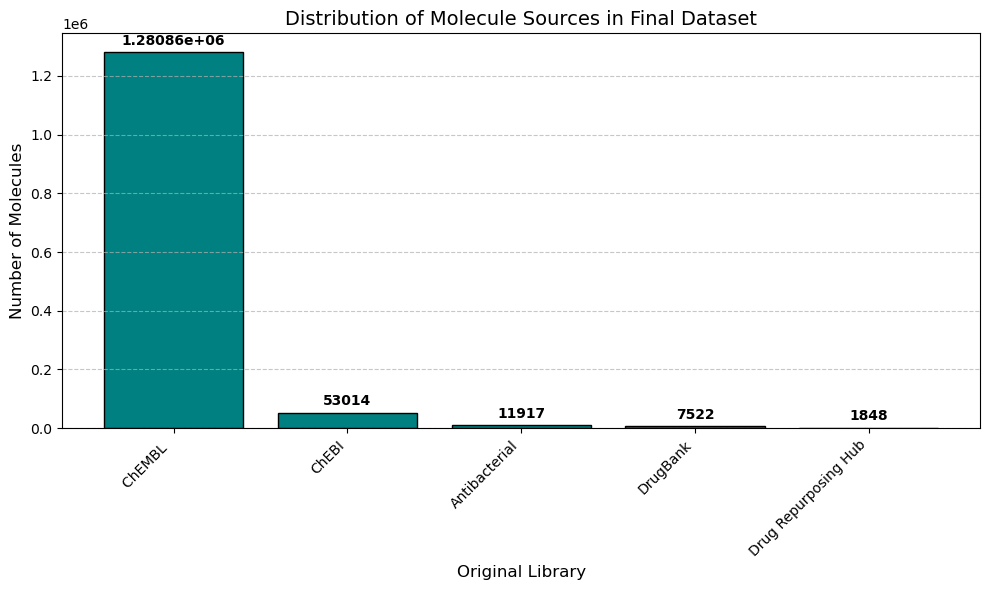

In [36]:
import matplotlib.pyplot as plt

# 1. Create a mapping from priority number to dataset name
priority_map = {
    1: 'DrugBank',
    2: 'Drug Repurposing Hub',
    3: 'Antibacterial',
    4: 'ChEBI',
    5: 'ChEMBL '
}

# 2. Map the priority column to the names
representatives['Source'] = representatives['priority'].map(priority_map)

# 3. Calculate counts for each source in the FINAL dataset
source_counts = representatives['Source'].value_counts().sort_values(ascending=False)

# 4. Generate the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(source_counts.index, source_counts.values, color='teal', edgecolor='black')

# --- NEW: Add counts on top of bars ---
ax.bar_label(bars, padding=3, fontsize=10, fontweight='bold')

# Add titles and labels
plt.title('Distribution of Molecule Sources in Final Dataset', fontsize=14)
plt.xlabel('Original Library', fontsize=12)
plt.ylabel('Number of Molecules', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and save
plt.tight_layout()
plt.savefig('molecule_source_distribution.png')

# 5. Create a dictionary of total molecules in the original datasets
# (Using the dataframes you mentioned were loaded)


# 6. Print the summary table with both Final Counts and Original Totals
print(f"{'Source':<25} | {'Final Count':<12}")
print("-" * 55)
for source in priority_map.values():
    final = source_counts.get(source, 0)
    print(f"{source:<25} | {final:<12}")

# Clean up
representatives.drop(columns=['Source'], inplace=True)

In [ ]:

representatives = {}
for idx, c in enumerate(labels):
    if c not in representatives:
        representatives[c] = idx

rep_indices = np.array(list(representatives.values()))
rep_smiles = [smiles_list[i] for i in rep_indices]

df_rep = pd.DataFrame({"SMILES": rep_smiles})
df_rep.to_csv("reference_set.csv", index=False)
